# TITLE

## Import the libs and Load the datasets

In [287]:
# Import libraries

# Data Loading
import numpy as np
import pandas as pd

# Data Querying
import pandasql

# Modelling
import statsmodels.formula.api as smf

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [288]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame> combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

In [289]:
def impute(data, value):
    """
    Function to impute a missing data (array-like) with a certain value
    
    :param data: array-like, the data with missing values
    :param value: float/int, the value to use for imputing missing values
    :return imputed_array: array-like, the imputed data
    """    
    # Check for each element in data 
    # return True if it's a missing values (represented as NaN in numpy) 
    # return False otherwise.
    bool_nan = np.isnan(data)
    
    # Return the value a_impute where a is missing and returns a otherwise
    imputed_data = np.where(bool_nan, value, data)
    
    return imputed_data

In [290]:
# Load dataset: Movie Titles
df_mv_titles = pd.read_csv("movie_titles.csv")
df_mv_titles.head()

,Title,Domestic,International,Budget,Distributor,MPAA-Rating,Runtime,Genres
0,Jurassic World (2015),652270625,1018130012,150000000.0,Universal Pictures,PG-13,124,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),936662225,1131561399,245000000.0,Walt Disney Studios Motion Pictures,PG-13,138,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),459005868,943800000,250000000.0,Walt Disney Studios Motion Pictures,PG-13,141,Action;Adventure;Sci-Fi
3,Inside Out (2015),356461711,501149463,175000000.0,Walt Disney Studios Motion Pictures,PG,95,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),353007020,1162040651,190000000.0,Universal Pictures,PG-13,137,Action;Adventure;Thriller


In [291]:
# Load dataset: Movie Daily Earnings
df_mv_daily_earnings = pd.read_csv("movie_daily_earnings.csv")
df_mv_daily_earnings.head()

,Movie_Title,Date,Daily,Theaters,Rank
0,Jurassic World (2015),2015-06-12,81953950,4274.0,1
1,Jurassic World (2015),2015-06-13,69644830,4274.0,1
2,Jurassic World (2015),2015-06-14,57207490,4274.0,1
3,Jurassic World (2015),2015-06-15,25344820,4274.0,1
4,Jurassic World (2015),2015-06-16,24342515,4274.0,1


## Check Missing Value

In [292]:
#Check missing value: Movie Titles
df_mv_titles.isnull().sum()/df_mv_titles.shape[0]*100

Title             0.000000
Domestic          0.000000
International     0.000000
Budget           32.147059
Distributor       0.029412
MPAA-Rating       4.588235
Runtime           0.000000
Genres            0.088235
dtype: float64

Movie Tiltes: variable(s) with missing value:
1. Budget (32%)
2. Distributor (0.03%)
3. MPAA-Rating (4.5%)
4. Genres (0.09%)

In [293]:
#Check missing value: Movie Daily Earnings
df_mv_daily_earnings.isnull().sum()/df_mv_daily_earnings.shape[0]*100

Movie_Title    0.000000
Date           0.000000
Daily          0.000000
Theaters       0.017319
Rank           0.000000
dtype: float64

Movie Daily Earnings: variable(s) with missing value:
1. Theaters (0.17%)

## Data Imputation

### Movie Daily Earnings Table

#### Handling Missing Values of Categotical Variables
We'll use mode-imputation to handle missing value of these categorical variables:
1. Theaters

In [294]:
# Fill the Theater's missing value using the mode
df_mv_daily_earnings['Theaters'].fillna(df_mv_daily_earnings['Theaters'].mode()[0], inplace=True)


In [295]:
#Check the missing value again: Movie Daily Earnings
df_mv_daily_earnings.isnull().sum()/df_mv_daily_earnings.shape[0]*100

Movie_Title    0.0
Date           0.0
Daily          0.0
Theaters       0.0
Rank           0.0
dtype: float64

Note: No longer any missing value in Movie Daily Earnings dataset

### Movie Titles Table

#### Handling Missing Values of Categotical Variables

We'll use mode-imputation to handle missing value of these categorical variables:
1. Distributor
2. MPAA-Rating
3. Genres

In [296]:
# Fill the Distributor's missing value using the mode
df_mv_titles['Distributor'].fillna(df_mv_titles['Distributor'].mode()[0], inplace=True)

In [297]:
# Fill the Distributor's missing value using the mode
df_mv_titles['MPAA-Rating'].fillna(df_mv_titles['MPAA-Rating'].mode()[0], inplace=True)


In [298]:
# Fill the Distributor's missing value using the mode
df_mv_titles['Genres'].fillna(df_mv_titles['Genres'].mode()[0], inplace=True)


In [299]:
#Check again the missing value: Movie Titles
df_mv_titles.isnull().sum()/df_mv_titles.shape[0]*100

Title             0.000000
Domestic          0.000000
International     0.000000
Budget           32.147059
Distributor       0.000000
MPAA-Rating       0.000000
Runtime           0.000000
Genres            0.000000
dtype: float64

Note: There's no longer any missing value in those categorical variables.

#### Handling Missing Values of Numerical Variable

There's one numerical variable with missing values:
1. Budget

We'll use these imputation methods to handle the missing value and find which method perform the best.
1. Complete Case Analysis
2. Deterministic Regression Imputation
3. Iterative Regression Imputation

##### 0. Preparing a New Target Variable for the Model Fitting

To make the data more comprehensible, we'll create a new column, Total Earnings, by adding the Domestic and International earning columns.

In [300]:
# Change the headers of the table
dict = {'Domestic': 'domestic',
        'International': 'international',
        'Budget': 'budget',
        'Distributor': 'distributor',
        'MPAA-Rating': 'mpaa_rating',
        'Runtime': 'runtime',
        'Genres': 'genres'
        }
 
# Rename the headers based on the dict using rename () method
df_mv_titles.rename(columns=dict, inplace=True)
 

##### 1. Complete Case Analysis

**Evaluate the dataset shape**

In [301]:
# Check the size of our original data
df_mv_titles.shape

(3400, 8)

In [302]:
# Drop all rows that contain missing data
df_mv_titles_compl_case = df_mv_titles.dropna(axis = 0)

# Check the size of data after row deletion
df_mv_titles_compl_case.shape

(2307, 8)

- We get that the table contains 2307 rows of complete data
- We'll build a regression model based on this complete data and evaluation it

In [303]:
df_mv_titles_compl_case.head()

,Title,domestic,international,budget,distributor,mpaa_rating,runtime,genres
0,Jurassic World (2015),652270625,1018130012,150000000.0,Universal Pictures,PG-13,124,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),936662225,1131561399,245000000.0,Walt Disney Studios Motion Pictures,PG-13,138,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),459005868,943800000,250000000.0,Walt Disney Studios Motion Pictures,PG-13,141,Action;Adventure;Sci-Fi
3,Inside Out (2015),356461711,501149463,175000000.0,Walt Disney Studios Motion Pictures,PG,95,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),353007020,1162040651,190000000.0,Universal Pictures,PG-13,137,Action;Adventure;Thriller


**Build the regression model**

In [304]:
# # Create the OLS model object and fit the model
# model_cca = smf.ols("budget ~ domestic + international + C(distributor) \
#                                 + C(mpaa_rating) + runtime \
#                                 + C(genres)", df_mv_titles_compl_case).fit()

Note: Distributor, MPAA-Rating, and Genres variables are not included because these variables can't be used in other imputation methods. Thus, we can't compare the models' standard error of these variables.

In [305]:
# Create the OLS model object and fit the model: without the categorical variable
model_cca = smf.ols("budget ~ domestic + international + runtime", df_mv_titles_compl_case).fit()

**Evaluate the model and store the evaluation**

In [306]:
r_squared = pd.DataFrame({"rsquared_cca" : [model_cca.rsquared]})
standard_error = pd.DataFrame({"standard_error_cca" : model_cca.bse})

In [307]:
r_squared

,rsquared_cca
0,0.532898


In [308]:
standard_error

,standard_error_cca
Intercept,4.497150e+06
domestic,1.644102e-02
international,9.004934e-03
runtime,4.161776e+04


##### 2. Deterministic Regression Imputation

In [309]:
# Check the percentage of missing value
df_mv_titles.isnull().sum()/df_mv_titles.shape[0]*100

Title             0.000000
domestic          0.000000
international     0.000000
budget           32.147059
distributor       0.000000
mpaa_rating       0.000000
runtime           0.000000
genres            0.000000
dtype: float64

We will only use the 68% of the data where all variables is complete as the predictors

In [310]:
# Exclude earning missing cases
df_mv_titles_det = df_mv_titles.dropna(subset=['budget'])

In [311]:
# Check percentage missing value in deterministic dataset
df_mv_titles_det.isnull().sum()/df_mv_titles_det.shape[0]*100

Title            0.0
domestic         0.0
international    0.0
budget           0.0
distributor      0.0
mpaa_rating      0.0
runtime          0.0
genres           0.0
dtype: float64

**Build a regression model using the complete dataset**

In [312]:
# Create the OLS model object and fit the model
model_det_reg = smf.ols("budget ~ domestic + international + runtime", df_mv_titles_det).fit()

Note: Distributor, MPAA-Rating, and Genres variables are not included because there's a value that only exist in the missing row. Thus, there will be and error when we try to predict the target variable.

**Prediction the missing budget variables using the model and impute the result to the missing values**

In [313]:
## Create a predictors dataframe by removing the budget column
df_mv_titles_predictors = df_mv_titles.drop(columns=["budget"])

In [314]:
# Predict the budget using the deterministic model
pred_budget_det = model_det_reg.predict(df_mv_titles_predictors)

**Impute the predicted values**

In [315]:
# Impute the budget variables
# Store the complete earnings that imuputed by deterministic value from regression prediction in a new variable

df_mv_titles["imp_budget_det_reg"] = impute(df_mv_titles['budget'], pred_budget_det)

In [316]:
df_mv_titles.isna().sum()

Title                    0
domestic                 0
international            0
budget                1093
distributor              0
mpaa_rating              0
runtime                  0
genres                   0
imp_budget_det_reg       0
dtype: int64

- `imp_budget_det_reg` has 0 missing data
- We'll build a regression model using that imputed variable and then evaluate the performance

**Build a regression model using the imputed budget variable**

In [317]:
# Create the OLS model object and fit the model
model_det_reg_2 = smf.ols("imp_budget_det_reg ~ domestic + international + runtime", df_mv_titles).fit()

**Evaluate the model and store the evaluation**

In [318]:

r_squared["rsquared_det_reg"] = model_det_reg_2.rsquared
standard_error["standard_error_det_reg"] = model_det_reg_2.bse

In [319]:
r_squared

,rsquared_cca,rsquared_det_reg
0,0.532898,0.591674


In [320]:
standard_error

,standard_error_cca,standard_error_det_reg
Intercept,4.497150e+06,2.952277e+06
domestic,1.644102e-02,1.170837e-02
international,9.004934e-03,6.529237e-03
runtime,4.161776e+04,2.737619e+04


##### 3. Random Regression Imputation

##### 4. Iterative Regression Imputation

## Join the Tables using Pandasql

## Create Scatter Matrix

In [ ]:
# def print_coef_std_err(results):
#     """
#     Function to combine estimated coefficients and standard error in one DataFrame
#     :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
#     :return df: <pandas DataFrame> 
#     """
#     coef = results.params
#     std_err = results.bse
    
#     df = pd.DataFrame(data = np.transpose([coef, std_err]), 
#                       index = coef.index, 
#                       columns=["coef","std err"])
#     return df

In [ ]:
# predictor = "x"
# outcome = "y"
# data = fake.copy()
# results_ = results_coef_std.copy()

# # Plot the data
# plt.scatter(data[predictor], data[outcome], marker=".", label="Data", color = "k")

# # Calculate the fitted values
# a_hat = results_.loc["Intercept"]["coef"]
# b_hat = results_.loc[predictor]["coef"]

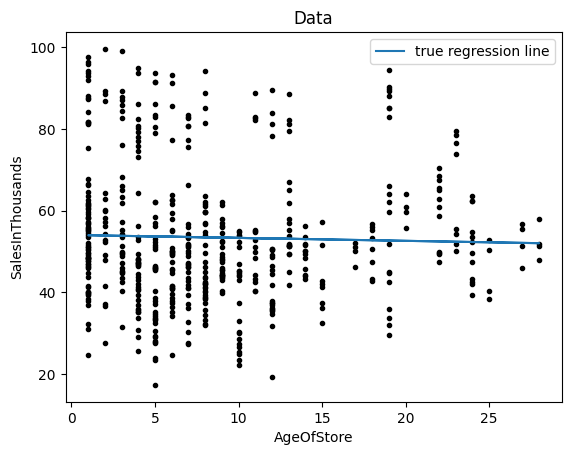

In [20]:
# Plot the data
var_x = "AgeOfStore"
var_y = "SalesInThousands"
a = 54.0786 #variablenya bisa dibikin dynamic
b = -0.072 #variablenya bisa dibikin dynamic

plt.scatter(df[var_x], df[var_y], marker=".", color = "k")
plt.plot(df[var_x], a + b * df[var_x], label = "true regression line")

# Add a legend and labels
plt.legend()
plt.xlabel(var_x)
plt.ylabel(var_y)

# Add a title 
plt.title("Data")
# Show the plot
plt.show()

In [ ]:
#plotting regression line

predictor = "weight"
outcome = "mpg"
data = auto.copy()
results_ = results_weight.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

In [ ]:
#Plotting residual plot
plt.scatter(results_model_weight.fittedvalues, results_model_weight.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

In [ ]:
#Calculate the R-squared
results_model_weight.rsquared

In [ ]:
#Plot histogram of residual to check the normality
plt.hist(results_model_weight.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

In [ ]:
#Log Transformation on a parameter
auto['logweight'] = np.log(auto["weight"])
auto.head(3)

# Create OLS model object
model = smf.ols("mpg ~ logweight", auto)

# Fit the model
results_logtransform = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_weight_log = print_coef_std_err(results_logtransform)

results_logtransform.rsquared

In [ ]:
#Reciprocal transformation on a parameter
auto['rec_weight'] = 1/auto["weight"]
auto.head(3)

# Create OLS model object
model = smf.ols("mpg ~ rec_weight", auto)

# Fit the model
results_rectransform = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_weight_rec = print_coef_std_err(results_rectransform)

results_rectransform.rsquared

In [ ]:
# Visualize the data with log transsformation
predictor = "logweight"
outcome = "mpg"
data = auto.copy()
results_ = results_weight_log.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

In [ ]:
# # Create a new Variable: Total Earnings
# df_mv_titles["tot_earnings"] = df_mv_titles["Domestic"] + df_mv_titles["International"]